In [214]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
import seaborn as sns
import plotting
import dataset_fctns
from scipy import stats


In [220]:
def subsample(ds, subsample_frac = 0.5):
    np.random.seed(0)
    subsample = np.random.choice(ds.shape[0],np.int64(np.floor(ds.shape[0]*subsample_frac)), replace = False)
    #print(np.arange(ds.shape[0]),np.int64(np.floor(ds.shape[0]*subsample_frac)))
    ds_training = ds.loc[subsample, :]
    complement_of_subsample = np.delete(np.arange(ds.shape[0]), subsample)
    #print(len(complement_of_subsample), ds.shape[0], len(subsample))
    ds_verification = ds.loc[complement_of_subsample, :]
    return ds_training, ds_verification

def make_cumulative(ds, driver_variable = 'tas', numdays = 200):
    ds[[f'{driver_variable} day {n}' for n in range(numdays)]] = ds[[f'{driver_variable} day {n}' for n in range(numdays)]].cumsum(axis = 1)
    return ds

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

def r2_modelled_observed(ds, phases):
    for phase in phases:
        print(f'\n{phase}')
        model_perts = ds[f'modelled time to {phase}'].dropna().values# - ds[f'modelled time to {phase}'].dropna().values.mean()
        obs_perts = ds[f'observed time to {phase}'].dropna().values# - ds[f'observed time to {phase}'].dropna().values.mean()
        RF_perts = ds[f'RF to {phase}'].dropna().values #- ds[f'RF to {phase}'].dropna().values.mean()
        r2_score_model = r2_score(obs_perts, model_perts)#.dropna()_score
        r2_score_RF = r2_score(obs_perts, RF_perts)#
        print(f'\nmodelled time emergence to {phase}, R2 score: {r2_score_model}', 
              f'\nML prediction emergence to {phase}, R2 score: {r2_score_RF}')
        
def box_plot_modelled_observed(ds, phases, font_size = 20):
    for phase in phases:
        fig, ax = plt.subplots(figsize = (10, 10))
        r2_score_model = r2_score(ds[f'observed time to {phase}'].dropna().values, ds[f'modelled time to {phase}'].dropna().values)
        r2_score_RF = r2_score(ds[f'observed time to {phase}'].dropna().values, ds[f'RF to {phase}'].dropna().values)
        ax.boxplot([ds[f'modelled time to {phase}'].dropna(), 
                    ds[f'RF to {phase}'].dropna(), 
                    ds[f'observed time to {phase}'].dropna()], 
                   tick_labels=[f'modelled time emergence to\n{phase},\nR2 score: {r2_score_model}', 
                                f'ML prediction emergence to\n{phase},\nR2 score: {r2_score_RF}', 
                                f'observed time emergence to\n{phase}'], 
                   widths = 0.5, showfliers=False) #positions = [obs_this_phase['Stations_id'].unique()[0]],
        #ax.set_ylim(0, 100)
        plt.xticks(rotation = 90)
        ax.tick_params(labelsize = font_size)
        ax.set_title(f'Modelled and observed times to {phase}', fontsize = font_size)
        ax.set_ylabel('Time (days)', fontsize = font_size)
        fig.savefig(f'plots/ML_modelled_observed_{phase}.png', bbox_inches='tight')

In [98]:
def test_hyperparameters(ds_training, ds_verification, driver_variable = 'tas', numdays = 200, max_depth = 10, n_estimators = 100, min_samples_leaf = 1):
    X_train = ds_training[[f'{driver_variable} day {n}' for n in range(numdays)]].values
    y_train = ds_training[[f'observed time to {phase}' for phase in phases]].values
    X_test = ds_verification[[f'{driver_variable} day {n}' for n in range(numdays)]].values
    y_test = ds_verification[[f'observed time to {phase}' for phase in phases]].values
    RF = RandomForestClassifier(max_depth = max_depth, n_estimators = n_estimators, min_samples_leaf = min_samples_leaf)
    RF.fit(X_train, y_train)
    y_pred = RF.predict(X_test)
    r2_score_RF = r2_score(y_test, y_pred)
    print(f'\nmodelled time emergence to {phase}, R2 score: {r2_score_RF}')

In [99]:
def get_station_locations(dataset, ds_stations):
    ds_stations.index = ds_stations['Stations_id']
    lat = [ds_stations._get_value(row, col) for row, col in zip(dataset['Stations_id'], ['geograph.Breite' for count in range(len(dataset))])] #station_data.lookup(row_labels = dataset['Stations_id'], col_labels = ['geograph.Breite'])
    lon = [ds_stations._get_value(row, col) for row, col in zip(dataset['Stations_id'], ['geograph.Laenge' for count in range(len(dataset))])] #station_data._lookup(dataset['Stations_id'], ['geograph.Laenge'])
    dataset['lat'] = lat
    dataset['lon'] = lon
    dataset['lat'] = dataset['lat'].map(lambda x: x[0] if isinstance(x, float) == False else x)
    dataset['lon'] = dataset['lon'].map(lambda x: x[0] if isinstance(x, float) == False else x)
    return dataset

In [269]:
ds_LSP = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_times2.csv')
ds_reanalysis = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2.csv')
ds_reanalysis = ds_reanalysis.rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
ds = pd.merge(ds_LSP, ds_reanalysis, on=['Stations_Id', 'year'], how='outer')
ds = ds.dropna(subset=['observed time to beginning of flowering', 'emergence date'])
ds = ds.reset_index().drop(['index', 'Unnamed: 0_x', 'Unnamed: 0_y'], axis=1)
ds = make_cumulative(ds, driver_variable = 'tas', numdays = 200)
day_columns = ['mingrad', 'maxgrad', 'minday', 'maxday', 'second last 75 percentile', 'last 75 percentile', 'emergence date']
for colname in day_columns:
    ds[colname] = pd.to_datetime(ds[colname]).dt.dayofyear

In [270]:
ds['year'].unique()

array([2018, 2019, 2020, 2021, 2022, 2023, 2017], dtype=int64)

In [271]:
station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_24620\1289162695.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [272]:
ds_LSP = ds_LSP.rename(columns = {'Stations_Id': 'Stations_id'})
ds_LSP = get_station_locations(ds_LSP, station_data)
ds = ds_LSP
day_columns = ['mingrad', 'maxgrad', 'minday', 'maxday', 'second last 75 percentile', 'last 75 percentile']
for colname in day_columns:
    ds[colname] = pd.to_datetime(ds[colname]).dt.dayofyear

Text(0.5, 1.0, 'bad')

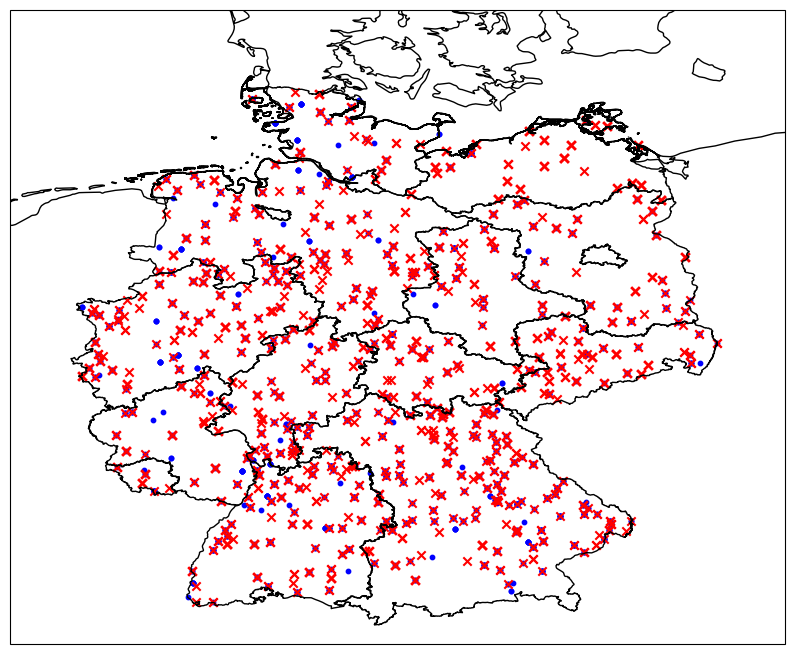

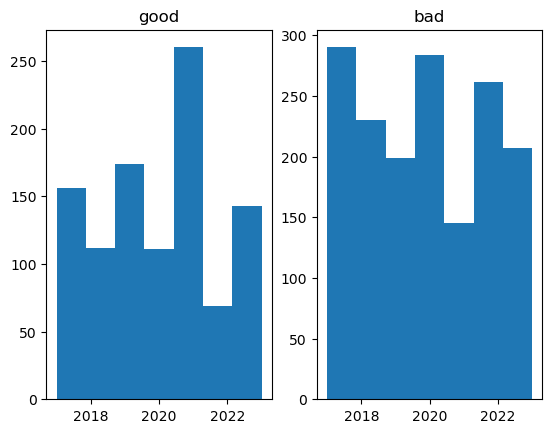

In [329]:
fig, ax = plotting.Germany_plot()
#ds_good_LSP = ds.where(ds['maxday'] > 150)
#ds_good_LSP = ds.where((ds['maxgrad'] < ds['mingrad']))#*(ds['year'] > 2020))
ds_good_LSP = ds.where((ds['second last 75 percentile'] > 150) * (ds['last 75 percentile'] > 150) * (ds['last 75 percentile'] < 270) * (ds['second last 75 percentile'] < 270))
#ds_bad_LSP = ds.where(ds['maxday'] < 150)
#ds_bad_LSP = ds.where((ds['maxgrad'] > ds['mingrad']))#*(ds['year'] > 2020))
ds_bad_LSP = ds.where(~((ds['second last 75 percentile'] > 150) * (ds['last 75 percentile'] > 150) * (ds['last 75 percentile'] < 270) * (ds['second last 75 percentile'] < 270)))
ax.scatter(ds_good_LSP['lon'], ds_good_LSP['lat'], c='blue', label='good', s = 10)
ax.scatter(ds_bad_LSP['lon'], ds_bad_LSP['lat'], c='red', label='bad', marker='x')

fig, ax = plt.subplots(1, 2)
ax[0].hist(ds_good_LSP['year'], bins=7)
ax[0].set_title('good')
ax[1].hist(ds_bad_LSP['year'], bins=7)
ax[1].set_title('bad')


In [330]:
def hist2d_proportions(lats, lons, subset_lats, subset_lons, bin_num=20, font_size = 20, title = 'Frequency of observations of ripeness time by location', colorname = 'Proportion of \'good\' observations', vmax = 0.6):
    hist_full, lonedges, latedges = np.histogram2d(lons, lats, bins=bin_num)#, range=[[0, 4], [0, 4]])
    hist_subset, lonedges, latedges = np.histogram2d(subset_lons, subset_lats, bins=bin_num)
    hist = (hist_subset/hist_full)*(hist_full>10)
    lonpos, latpos = np.meshgrid(lonedges, latedges, indexing="ij")#np.meshgrid(lonedges[:-1] + sizelon, latedges[:-1] + sizelat, indexing="ij")
    lonpos = lonpos#.ravel()
    latpos = latpos#.ravel()
    fig, ax = plotting.Germany_plot(figsize = (10, 10))
    ax.set_title(title, fontsize = font_size)
    densities = ax.pcolormesh(lonpos, latpos, hist, cmap='Purples', vmax = vmax, vmin = 0)
    cbar = plt.colorbar(densities, fraction = 0.03)
    cbar.set_label(label = colorname, size=font_size)
    cbar.ax.tick_params(labelsize=font_size - 2) 
    plt.show()

In [331]:
print(len(all_latlon), len(good_latlon))

2641 1563


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_24620\2737870593.py:4: RuntimeWarning: invalid value encountered in divide
  hist = (hist_subset/hist_full)*(hist_full>10)


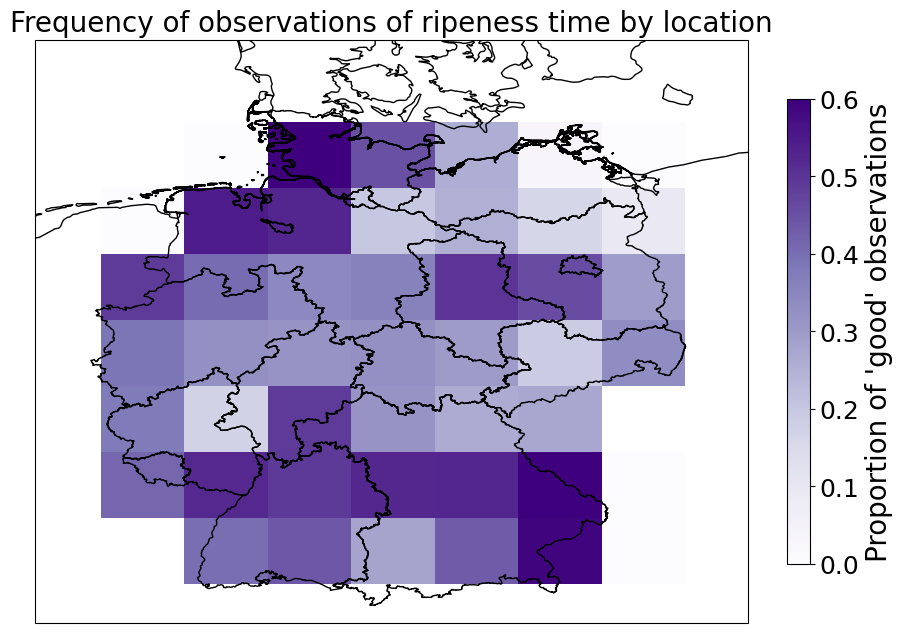

In [332]:
good_latlon = ds_good_LSP[['lat', 'lon']].dropna()
bad_latlon = ds_bad_LSP[['lat', 'lon']].dropna()
all_latlon = ds[['lat', 'lon']].dropna()
hist2d_proportions(all_latlon['lat'], all_latlon['lon'], good_latlon['lat'], good_latlon['lon'], bin_num = 7)

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_24620\2737870593.py:4: RuntimeWarning: invalid value encountered in divide
  hist = (hist_subset/hist_full)*(hist_full>10)


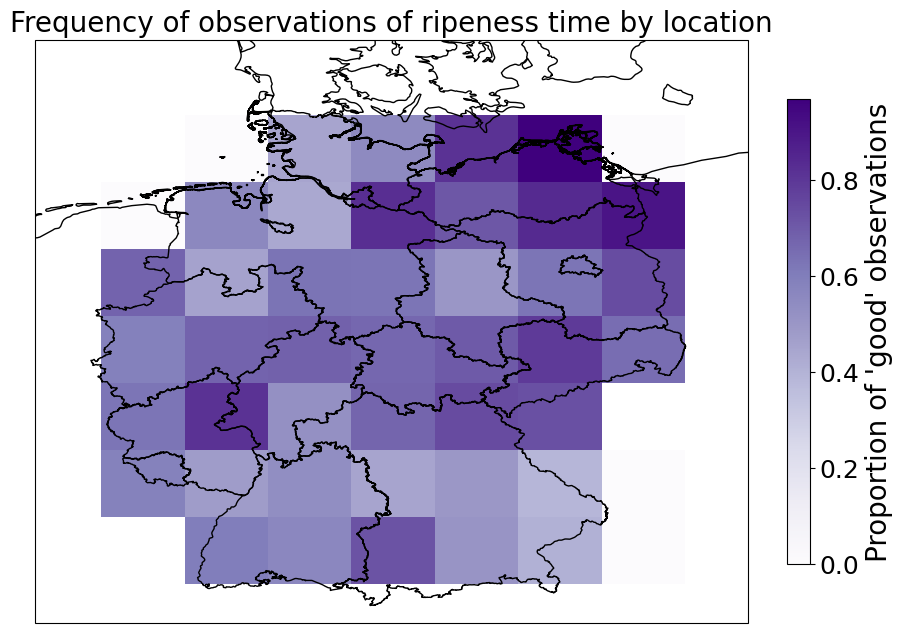

In [333]:
hist2d_proportions(all_latlon['lat'], all_latlon['lon'], bad_latlon['lat'], bad_latlon['lon'], bin_num = 7, vmax = None)

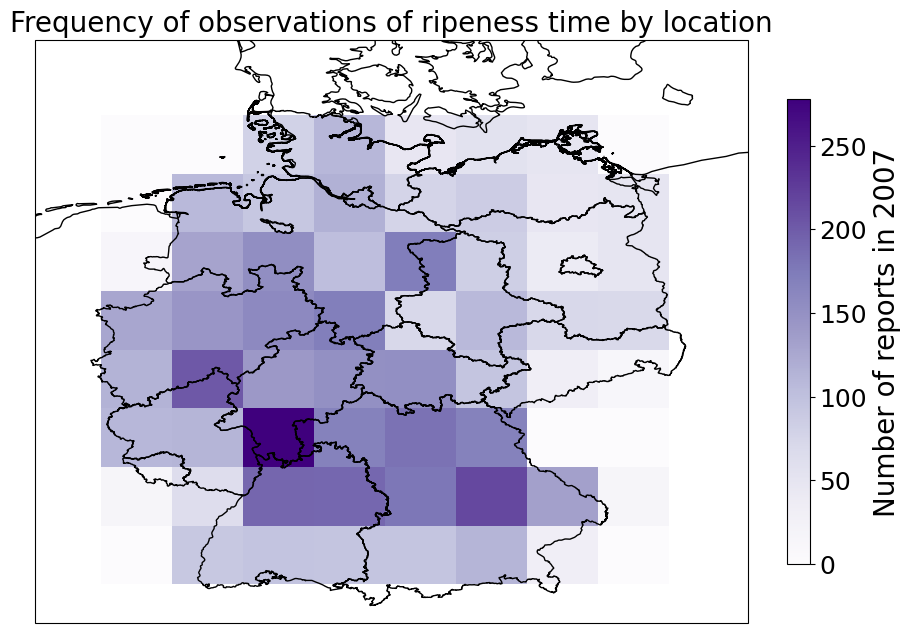

In [42]:
plotting.hist2d_locations(all_latlon['lat'], all_latlon['lon'], bin_num=8)

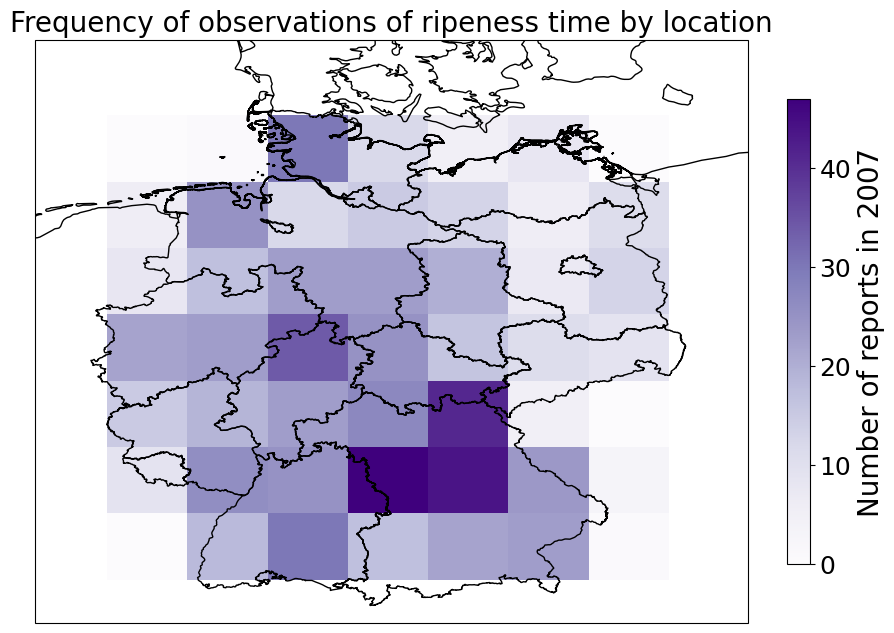

In [17]:
good_latlon = ds_good_LSP[['lat', 'lon']].dropna()
plotting.hist2d_locations(good_latlon['lat'], good_latlon['lon'], bin_num = 7)

In [19]:
len(good_latlon)

814

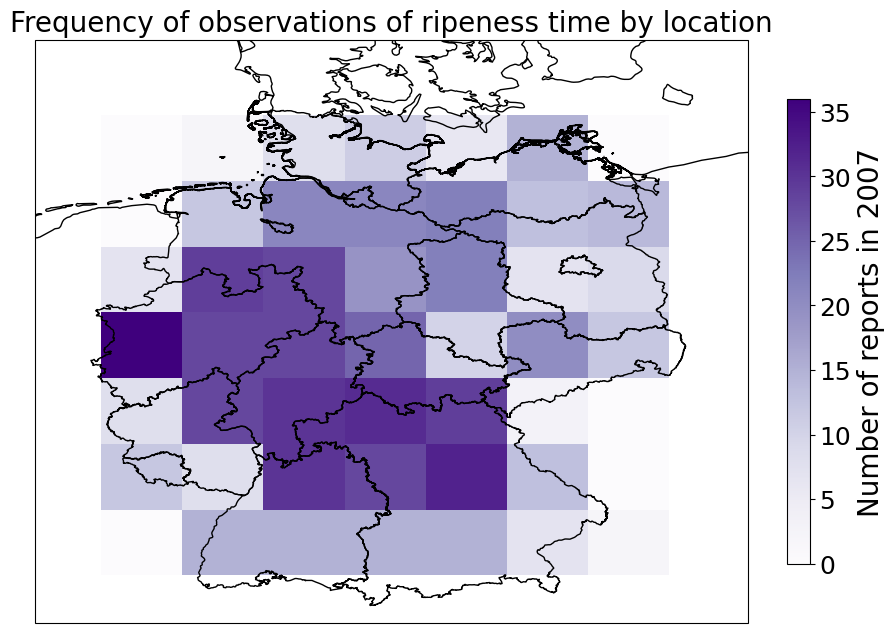

In [20]:
bad_latlon = ds_bad_LSP[['lat', 'lon']].dropna()
plotting.hist2d_locations(bad_latlon['lat'], bad_latlon['lon'], bin_num = 7)

In [82]:
len(ds.where(ds['modelled time to emergence'] < 400)['modelled time to emergence'].dropna())

1112

In [81]:
len(ds)

1673

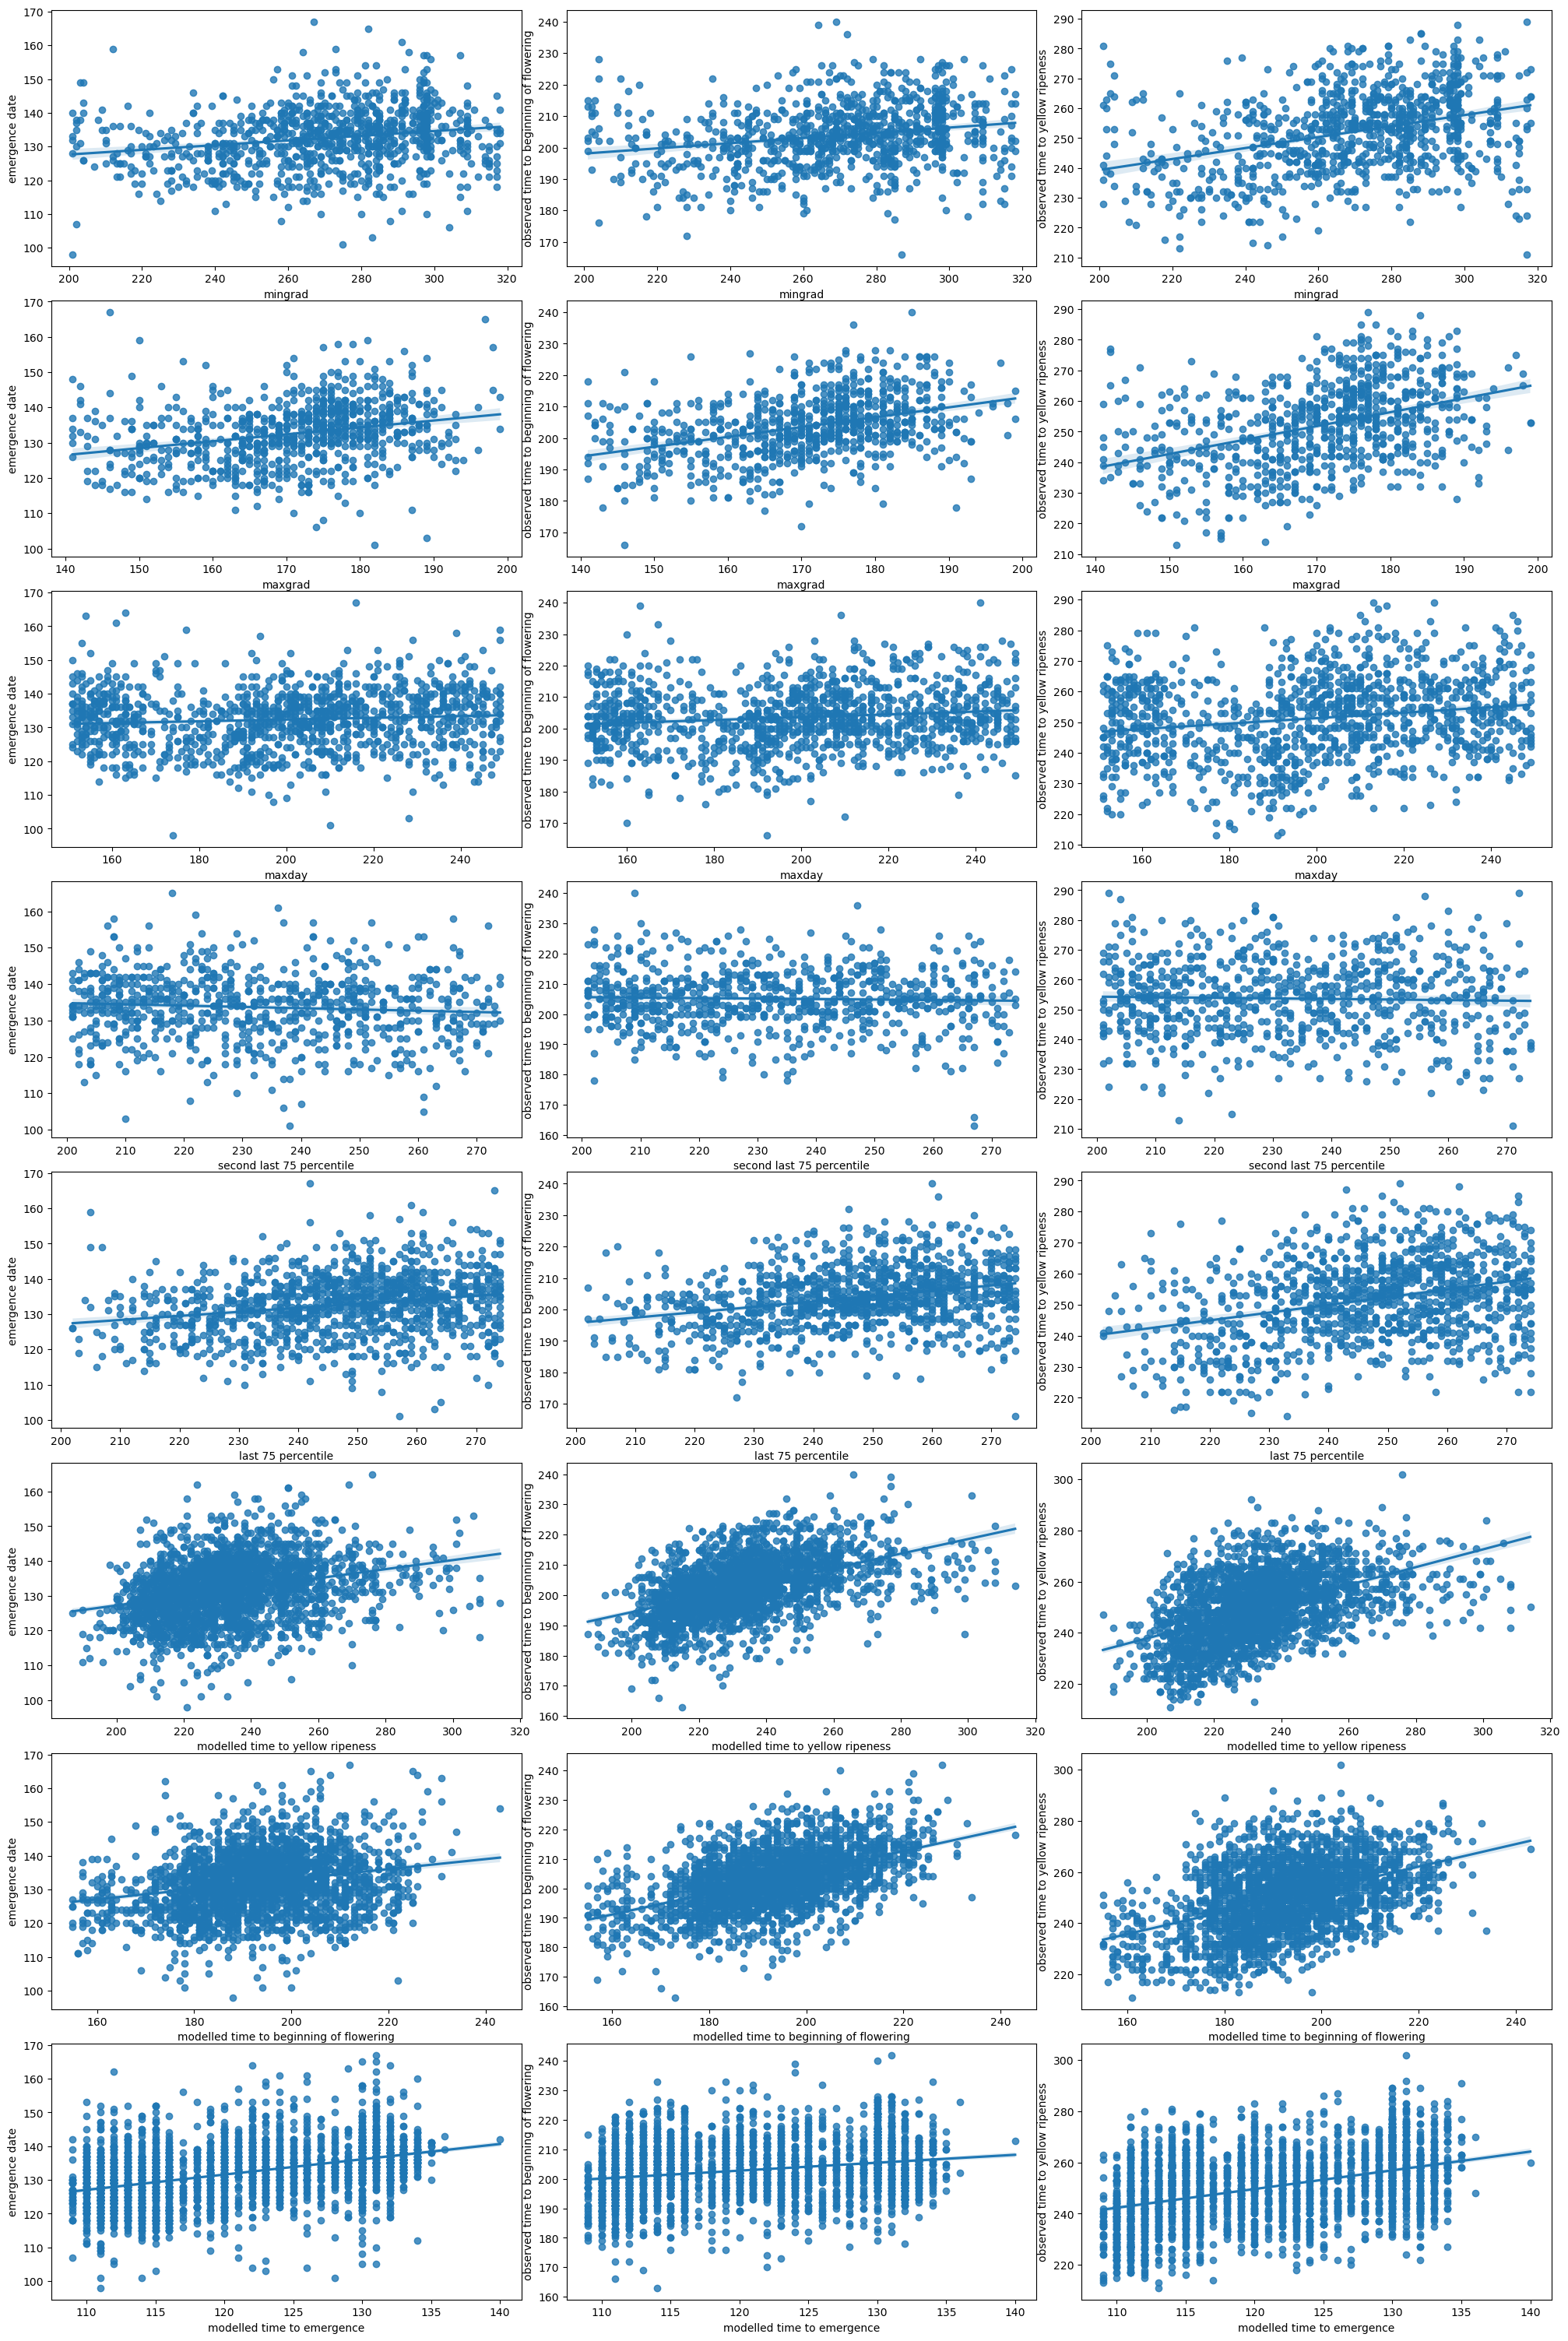

In [318]:
fig, axes = plt.subplots(8, 3, figsize = (20, 30))
fig.tight_layout()
predictors = ['mingrad', 'maxgrad', 'maxday', 'second last 75 percentile', 'last 75 percentile', 'modelled time to yellow ripeness', 'modelled time to beginning of flowering', 'modelled time to emergence']
observed_variables = ['emergence date', 'observed time to beginning of flowering', 'observed time to yellow ripeness']

ds_LSP = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_times2.csv')
ds_reanalysis = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data3.csv')
ds_reanalysis = ds_reanalysis.rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
ds = pd.merge(ds_LSP, ds_reanalysis, on=['Stations_Id', 'year'], how='outer')
ds = ds.dropna(subset=['observed time to beginning of flowering', 'emergence date'])
ds = ds.reset_index().drop(['index', 'Unnamed: 0_x', 'Unnamed: 0_y'], axis=1)
ds = make_cumulative(ds, driver_variable = 'tas', numdays = 200)
day_columns = ['mingrad', 'maxgrad', 'minday', 'maxday', 'second last 75 percentile', 'last 75 percentile', 'emergence date']
for colname in day_columns:
    ds[colname] = pd.to_datetime(ds[colname]).dt.dayofyear
ds['observed time to beginning of flowering'] = ds['observed time to beginning of flowering'] + ds['emergence date']
ds['observed time to yellow ripeness'] = ds['observed time to yellow ripeness'] + ds['emergence date']
ds['modelled time to emergence'] = ds['modelled time to emergence'] + pd.to_datetime(ds['WC SOS']).dt.dayofyear
ds['modelled time to beginning of flowering'] = ds['modelled time to beginning of flowering'] + ds['modelled time to emergence']
ds['modelled time to yellow ripeness'] = ds['modelled time to yellow ripeness'] + ds['modelled time to emergence']
for observed_variable in observed_variables:
    ds = ds.where((ds[observed_variable] < 365)*(ds[observed_variable] > 0))
for predictor_index, predictor in enumerate(predictors):
    for observed_variable_index, observed_variable in enumerate(observed_variables):
        if predictor == 'mingrad' or predictor == 'maxgrad':
            ds_no_outliers = ds.where(ds['mingrad'] > ds['maxgrad']).dropna(how='all')
            if predictor == 'mingrad':
                ds_no_outliers = ds_no_outliers.where((ds_no_outliers[predictor] > 200)).dropna(how='all')
            elif predictor == 'maxgrad':
                ds_no_outliers = ds_no_outliers.where((ds_no_outliers[predictor] < 200)*(ds_no_outliers[predictor] > 140)).dropna(how='all')
        elif predictor == 'maxday':
            ds_no_outliers = ds.where((ds[predictor] < 250)*(ds[predictor] > 150)).dropna(how='all')
        elif predictor == 'second last 75 percentile' or predictor == 'last 75 percentile':
            ds_no_outliers = ds.where((ds[predictor] < 275)*(ds[predictor] > 200)).dropna(how='all')
        elif predictor == 'modelled time to emergence' or predictor == 'modelled time to beginning of flowering' or predictor == 'modelled time to yellow ripeness':
            ds_no_outliers = ds.where(ds[predictor] < 365).dropna(how='all')
            #if predictor == 'modelled time to beginning of flowering' or predictor == 'modelled time to yellow ripeness':
            #    ds_no_outliers = ds_no_outliers.where(ds_no_outliers[predictor] > ds_no_outliers['modelled time to emergence'] + 5).dropna(how='all')
        else:
            ds_no_outliers = ds
        

        sns.regplot(x=predictor, y=observed_variable, data=ds_no_outliers, ax=axes[predictor_index, observed_variable_index])

In [374]:
ds_LSP = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_times2.csv')
ds_reanalysis = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data3.csv')
ds_reanalysis = ds_reanalysis.rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
ds = pd.merge(ds_LSP, ds_reanalysis, on=['Stations_Id', 'year'], how='outer')
ds = ds.dropna(subset=['observed time to yellow ripeness', 'emergence date'])
ds = ds.where(ds['observed time to yellow ripeness'] > 0).dropna(how='all')
ds = ds.reset_index().drop(['index', 'Unnamed: 0_x', 'Unnamed: 0_y'], axis=1)
ds = make_cumulative(ds, driver_variable = 'tas', numdays = 200)
day_columns = ['mingrad', 'maxgrad', 'minday', 'maxday', 'second last 75 percentile', 'last 75 percentile', 'emergence date']
for colname in day_columns:
    ds[colname] = pd.to_datetime(ds[colname]).dt.dayofyear
ds = ds.where((ds['last 75 percentile'] < 275)*(ds['last 75 percentile'] > 200)).dropna(how='all')
ds = ds.where(ds['maxgrad'] < ds['mingrad']).dropna(how='all')
thinning_num = 40
training_columns = ['mingrad', 'maxgrad', 'last 75 percentile'] + ['modelled time to emergence', 'modelled time to beginning of flowering', 'modelled time to yellow ripeness'] #+ ['mingrad', 'maxgrad', 'last 75 percentile'] +[f'tas day {thinning_num*n}' for n in range(np.int64(200/thinning_num))]  #['mingrad', 'maxgrad', 'minday', 'maxday',  'second last 75 percentile', 'last 75 percentile'] #
response_columns =['observed time to yellow ripeness']# ['observed time emergence to beginning of flowering', 'emergence date']#['observed time emergence to beginning of flowering', 'observed time emergence to yellow ripeness', 'emergence date']#['observed time emergence to yellow ripeness']#
ds2 = ds.dropna(subset = training_columns + response_columns).reset_index()
training, verification = subsample(ds2, subsample_frac = 0.9)

In [375]:
clf = RandomForestClassifier(n_estimators=100,
                             max_depth = 3,
                             min_samples_leaf=2)
from sklearn.ensemble import GradientBoostingRegressor
clf = GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0,
    loss='squared_error'
)
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(max_depth=1, random_state=0, min_samples_leaf=1)
X_training = training[training_columns].values
y_training = training[response_columns].values.ravel()
X_eval = verification[training_columns].values
y_eval = verification[response_columns].values.ravel()
clf_fit = clf.fit(X_training, y_training)

In [376]:
phase_list = ['yellow ripeness']#['beginning of flowering', 'emergence']#['beginning of flowering', 'yellow ripeness', 'emergence']
for phase_index, phase in enumerate(phase_list):
    training.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:, 
    verification.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:, 
    training[f'ML check obs to {phase}'] = y_training#[phase_index]#:, 
    verification[f'ML check obs to {phase}'] = y_eval#[phase_index]#:, 
verification['verification'] = 'verification'
training['verification'] = 'training'
ds_results = pd.concat([verification, training], axis=0)
ds_results['modelled time to emergence'] = ds_results['modelled time to emergence'] + pd.to_datetime(ds_results['WC SOS']).dt.dayofyear
ds_results['modelled time to emergence']
ds_results = ds_results.rename(columns = {'observed time emergence to beginning of flowering': 'observed time to beginning of flowering', 
                                          'observed time emergence to yellow ripeness': 'observed time to yellow ripeness'})
ds_results['observed time to emergence'] = ds_results['emergence date']
r2_modelled_observed(ds_results.where(ds_results['verification'] == 'verification').dropna(how = 'all').dropna(subset=['modelled time to emergence']), ['yellow ripeness']) #['emergence', 'beginning of flowering'])#, 'yellow ripeness'



yellow ripeness

modelled time emergence to yellow ripeness, R2 score: -16.151520475693403 
ML prediction emergence to yellow ripeness, R2 score: 0.07374727145328897


In [377]:
X_eval = verification[training_columns].values
y_eval = verification[response_columns].values

r = permutation_importance(clf_fit, X_eval, y_eval,
                           n_repeats=30,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    #if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
    print(f"{training_columns[i]:<15}",
            f"{r.importances_mean[i]:.3f}",
            f" +/- {r.importances_std[i]:.3f}")

mingrad         0.107  +/- 0.044
modelled time to yellow ripeness 0.007  +/- 0.005
modelled time to emergence 0.001  +/- 0.006
modelled time to beginning of flowering 0.000  +/- 0.000
last 75 percentile 0.000  +/- 0.000
maxgrad         -0.001  +/- 0.003


In [258]:
len(training_columns)

16

KeyError: 'RF to emergence'

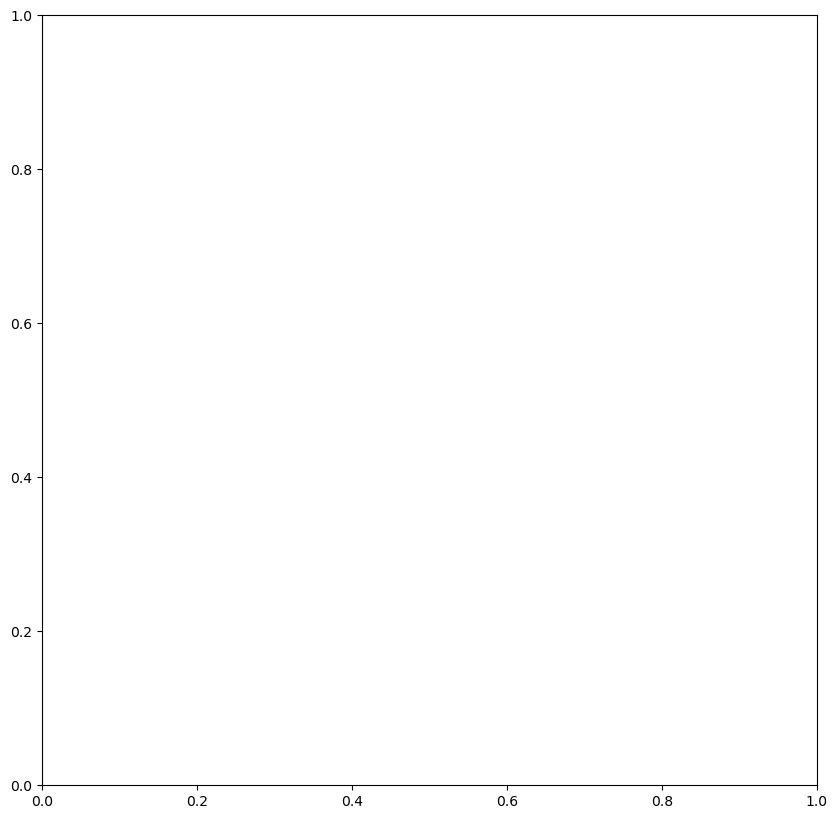

In [247]:
box_plot_modelled_observed(ds_results.where(ds_results['verification'] == 'verification').dropna(how = 'all').dropna(subset=['modelled time to emergence']), ['emergence', 'beginning of flowering']) #, 'yellow ripeness'

ValueError: multiclass-multioutput is not supported